In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
#import xgboost as xgb
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import f_regression, SelectKBest, VarianceThreshold, SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
import datetime as dt
from scipy import stats


In [532]:
class TrainingManager(object):
    """
    target can be (cum_positive_density, cum_deceased_density, cum_recovered_density)
    """
    def __init__(self, ml_dataset_file_path, features=None,target="cum_positive_density"):
        
        assert target in ["cum_positive_density", "cum_deceased_density", "cum_recovered_density"], 'Error, target must be in ["cum_positive_density", "cum_deceased_density", "cum_recovered_density"]'
        
        
        self.population_dependent_features = ["farm_labour_force.tsv","available_hospital_beds_nuts2.tsv",
                "deaths.tsv",
                "hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv",
                "stock_of_vehicles_by_category_and_nuts2.tsv",
                "employment_thousand_hours_worked_nuts2.tsv",
                "stock_of_vehicles_by_category_and_nuts2.tsv",
                "students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv",
                "health_personnel_by_nuts2.tsv",
                "pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv",
                "early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv"]
        target_origin = target.replace("_density", "")
        
        df = pd.read_csv(ml_dataset_file_path, sep="\t", index_col=0)
        # check that target is correctly reported(some state reported 0 as deceased or recovered, 
        # but with large numbers of positives it clearly can't be the case for the 'cumulated target'(the target origin from which the density is computed) )
        df = df[ (df[target_origin].isna() == False) & (df[target_origin] > 0.)  ] 
        
        X = df.iloc[:,11:-3 ]
        
        
        national_means = pd.DataFrame()
        national_means[X.columns] = X[X.columns]
        # fill with national mean where possible
        national_means["iso3"] = df["iso3"]
        national_means = national_means.groupby(by="iso3" ).mean()

        iso3_aggregator_df = pd.DataFrame()
        iso3_aggregator_df["iso3"] = df[ "iso3" ]
        iso3_aggregator_df["nuts"] = iso3_aggregator_df.index
        iso3_aggregator_df = iso3_aggregator_df.merge(national_means, left_on="iso3", right_on="iso3")
        iso3_aggregator_df.set_index("nuts", inplace=True)
    
        for column in X.columns:
            X[column].fillna(iso3_aggregator_df[column], inplace=True)
            
            
        
        
        if features is not None:
            X = X[features]
            
        
        y = df[target] *100
        #y = df["cum_positive_density"] *100
    
        self.df = df
        self.X = X
        self.y = y
        
        self.shuffle = True
        self.test_size = 0.3
    
    def __remove_population_dependency(self):
        for column in self.population_dependent_features:
            self.X[column] = self.X[column] / self.X["population_nuts2.tsv"]
        #self.X[self.population_dependent_features] = self.X[self.population_dependent_features] / self.X["population_nuts2.tsv"]
    def __fillnans(self):
        self.X.fillna(self.X.mean(axis=0), inplace=True)
    def __standardize(self):
        # could standardize after splitting for technicalities of data leak of the dataset statistics
        self.X_mean = self.X.mean(axis=0)
        self.X_std = self.X.std(axis=0)
        self.X = (self.X - self.X.mean(axis=0))/ self.X.std(axis=0)
        
        
    def __train_test_split(self, test_size=0.3, shuffle=True):
        self.test_size = test_size
        self.shuffle = shuffle
        
        self.X_train_full, self.X_test, self.y_train_full, self.y_test = train_test_split(self.X, self.y, test_size=test_size, shuffle=shuffle)
        
    
    def __set_model(self, model):
        """
        pass as parameter a scikit-learn like model that supports the scikit fit, predict interfaces 
        """
        self.model = model
        # threshold for the feature selection is computed as the mean of the feature importances 
        # this can be read from the docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel
        self.pipeline = Pipeline( steps= [('feature_selection', SelectFromModel(RandomForestRegressor())),
                                          ("model",model)#RandomForestRegressor())#xgb.XGBRegressor(n_estimators=200, max_depth=5)),
                                                     ])
    def __set_cv(self, n_splits=10):
        self.n_splits = n_splits
        self.kf = KFold(n_splits=n_splits)
        
        
        
    def train_test(self,model, test_size=0.3, shuffle=True,n_splits=10, metric=r2_score):
        self.__fillnans()
        self.__remove_population_dependency()
        #self.__standardize()
        self.__train_test_split(test_size=test_size, shuffle=shuffle)
        self.__set_model(model)
        self.__set_cv(n_splits=n_splits)
        

        tot_train_score = 0
        tot_valid_score = 0
        tot_test_score = 0
        for train_index, valid_index in self.kf.split(self.X_train_full):

            #print("TRAIN:", train_index, "TEST:", valid_index)
            X_train, X_valid = self.X_train_full.iloc[train_index], self.X_train_full.iloc[valid_index]
            y_train, y_valid = self.y_train_full.iloc[train_index], self.y_train_full.iloc[valid_index]


           
            self.pipeline.fit(X_train, y_train)

            #cross_v
            y_train_preds = self.pipeline.predict(X_train)
            y_valid_preds = self.pipeline.predict(X_valid)
            y_test_preds = self.pipeline.predict(self.X_test)
 
            tot_train_score += metric(y_train, y_train_preds)
            tot_valid_score += metric(y_valid, y_valid_preds)
            tot_test_score += metric(self.y_test, y_test_preds)
        print("Train: ", tot_train_score/n_splits) 
        print("Valid: ", tot_valid_score/n_splits)
        print("Test: ", tot_test_score/n_splits)

        self.trained_model = self.pipeline["model"]

from tqdm import tqdm        

target = "cum_deceased_density"
tm = TrainingManager("ml_dataset.tsv", target=target) 
tm.train_test(RandomForestRegressor(), metric=mean_absolute_error,test_size=0.2)


selected_features = tm.X_train_full.columns[tm.pipeline["feature_selection"].get_support()]    
feature_importances = sorted(zip(selected_features, tm.trained_model.feature_importances_), key=lambda x: x[1], reverse=True )
for feature, importance in feature_importances:
    print(feature, " ", importance)


Train:  0.017697857892009138
Valid:  0.052489882899640974
Test:  0.049700246774533156
life_expectancy.tsv   0.5902787031729132
participation_in_education_and_training.tsv   0.23535617372889212
utilised_agricultural_area.tsv   0.1743651230981948


In [501]:
N_RUNS = 20
longrun_fimp_dict = dict()
for i in tqdm(range(N_RUNS)):
    tm = TrainingManager("ml_dataset.tsv", target=target) 
    tm.train_test(RandomForestRegressor(), metric=mean_absolute_error,test_size=0.2)


    selected_features = tm.X_train_full.columns[tm.pipeline["feature_selection"].get_support()]    
    feature_importances = sorted(zip(selected_features, tm.trained_model.feature_importances_), key=lambda x: x[1], reverse=True )
    for feature, importance in feature_importances:
        #print(feature, " ", importance)
        if feature not in longrun_fimp_dict:
            longrun_fimp_dict[feature] = [importance]
        else:
            longrun_fimp_dict[feature].append(importance)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:53<00:00,  2.68s/it]


In [502]:
res = dict()
for feature, importances in  longrun_fimp_dict.items():
    res[feature] = (sum(importances)/len(importances), len(importances))
sorted(res.items(), key=lambda x: x[1][0], reverse=True)

[('pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv',
  (0.3209502857074144, 20)),
 ('real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv',
  (0.1991006331784976, 19)),
 ('employment_thousand_hours_worked_nuts2.tsv', (0.14988769346738612, 20)),
 ('life_expectancy.tsv', (0.13976009779036605, 6)),
 ('unemployment_rate_nuts2.tsv', (0.1393004831639724, 18)),
 ('longterm_care_beds_per_hundred_thousand_nuts2.tsv',
  (0.1384945154045329, 9)),
 ('causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv',
  (0.12080291157336129, 9)),
 ('participation_in_education_and_training.tsv', (0.1186846219498891, 6)),
 ('students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv',
  (0.09449414355190716, 3)),
 ('deaths.tsv', (0.06441501568913902, 1)),
 ('hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv',
  (0.060677081573594374, 1))]

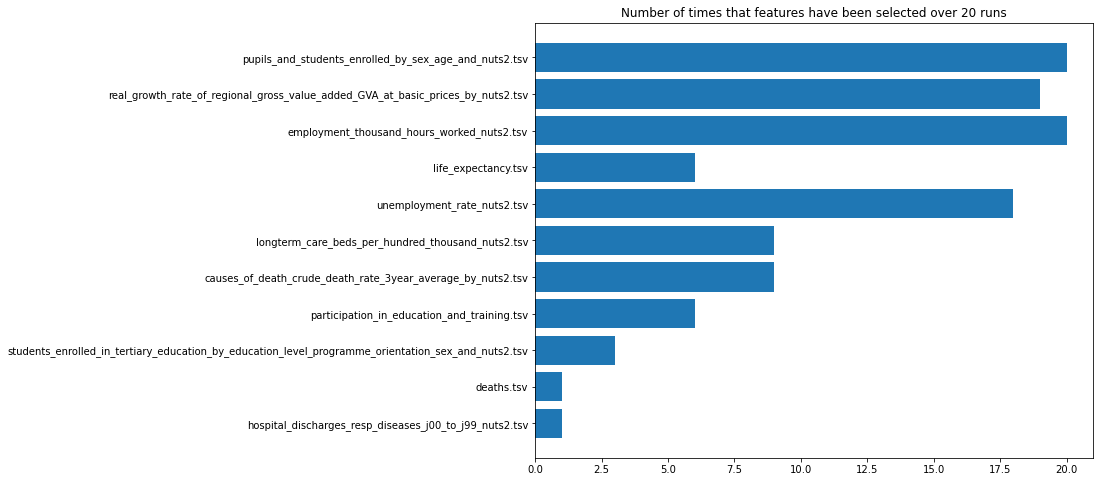

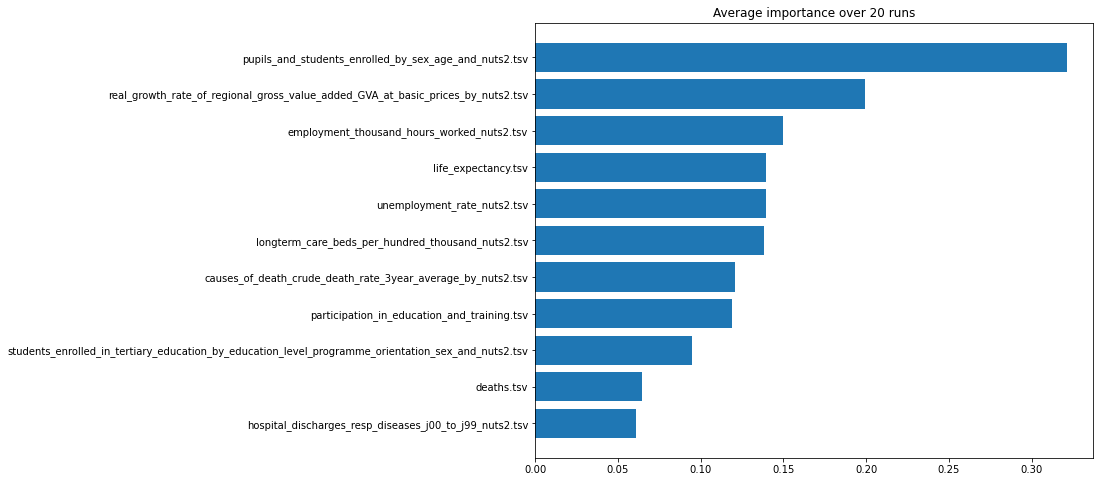

In [503]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
feature_importances = sorted(res.items(), key=lambda x: x[1][0])
used_feature_names = [ item[0]for item in feature_importances]
avg_importances = [ item[1][0] for item in feature_importances]
num_times_feature_is_selected = [ item[1][1] for item in feature_importances]
plt.title(F"Number of times that features have been selected over {N_RUNS} runs")
plt.barh(used_feature_names,num_times_feature_is_selected)
plt.savefig("../../9_aug_new/" +target +"_numtimes", bbox_inches='tight', dpi=600)
plt.figure(figsize=(10,8))
plt.title(F"Average importance over {N_RUNS} runs")
plt.barh(used_feature_names,avg_importances)
plt.savefig("../../9_aug_new/" +target +"_fimp", bbox_inches='tight', dpi=600)

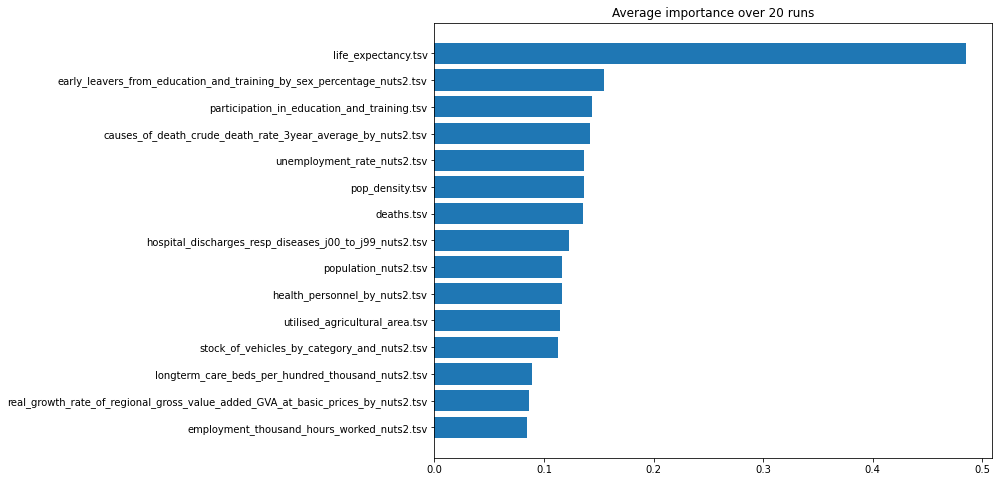

# feature importances


In [408]:
feature_importances = sorted(zip(tm.X.columns, tm.trained_model.feature_importances_), key=lambda x: x[1], reverse=True )
for feature, importance in feature_importances:
    print(feature, " ", importance)

compensation_of_employees_by_nuts2.tsv   0.16797434240884893
health_personnel_by_nuts2.tsv   0.1535408033281049
air_passengers.tsv   0.134948240411812
hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv   0.0819775325280969
causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv   0.08153679519015734
deaths.tsv   0.07436069451155695
farm_labour_force.tsv   0.07361208392890838
employment_thousand_hours_worked_nuts2.tsv   0.06110945181438985
available_hospital_beds_nuts2.tsv   0.05712807816502069
early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv   0.05691411078535615
life_expectancy.tsv   0.05689786692774785


In [251]:
"""
def get_top_k_features(tm, k=10):
    feature_importances = sorted(zip(tm.X.columns, tm.trained_model.feature_importances_), key=lambda x: x[1], reverse=True )
    return [feat_name for feat_name, importance in  feature_importances[:k]]
def print_feature_importances(tm):
    feature_importances = sorted(zip(tm.X.columns, tm.trained_model.feature_importances_), key=lambda x: x[1], reverse=True )
    for feature, importance in feature_importances:
        print(feature, " ", importance)
features = get_top_k_features(tm, k=8)


target = "cum_positive_density"
tm_postproc = TrainingManager("ml_dataset.tsv", target=target, features=features) 
tm_postproc.train_test(RandomForestRegressor(), metric=mean_absolute_error)
print_feature_importances(tm_postproc)
"""

Train:  0.7277964313679207
Valid:  1.8778343883265862
Test:  2.065001440408741
life_expectancy.tsv   0.2674153714848891
early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv   0.179601829697193
available_hospital_beds_nuts2.tsv   0.13423406202536142
pop_density.tsv   0.12781232641263035
participation_in_education_and_training.tsv   0.10957509353440063
longterm_care_beds_per_hundred_thousand_nuts2.tsv   0.06910009916377204
young_people_neither_in_employment_nor_in_education_and_training_by_sex_NEET_RATE_nuts2.tsv   0.061858641739310945
real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv   0.050402575942442594


<BarContainer object of 3 artists>

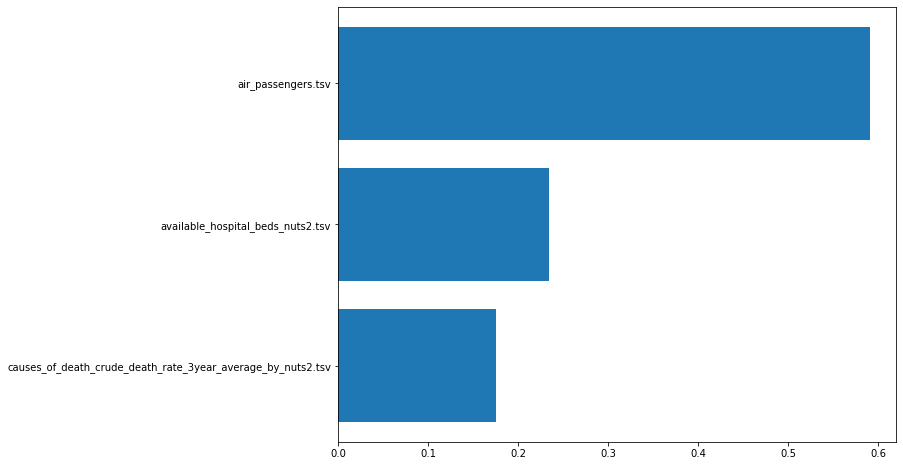

In [384]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
feature_importances = sorted(zip(tm.X.columns, tm.trained_model.feature_importances_), key=lambda x: x[1],  )
plt.barh([ item[0]for item in feature_importances], [ item[1]for item in feature_importances])

# shap values


In [526]:

import shap
shap_values = shap.TreeExplainer(tm.trained_model).shap_values(tm.X_train_full[])
shap.summary_plot(shap_values, tm.X_train_full, plot_type="bar")

SyntaxError: invalid syntax (<ipython-input-526-a6a76bb9ed3a>, line 2)

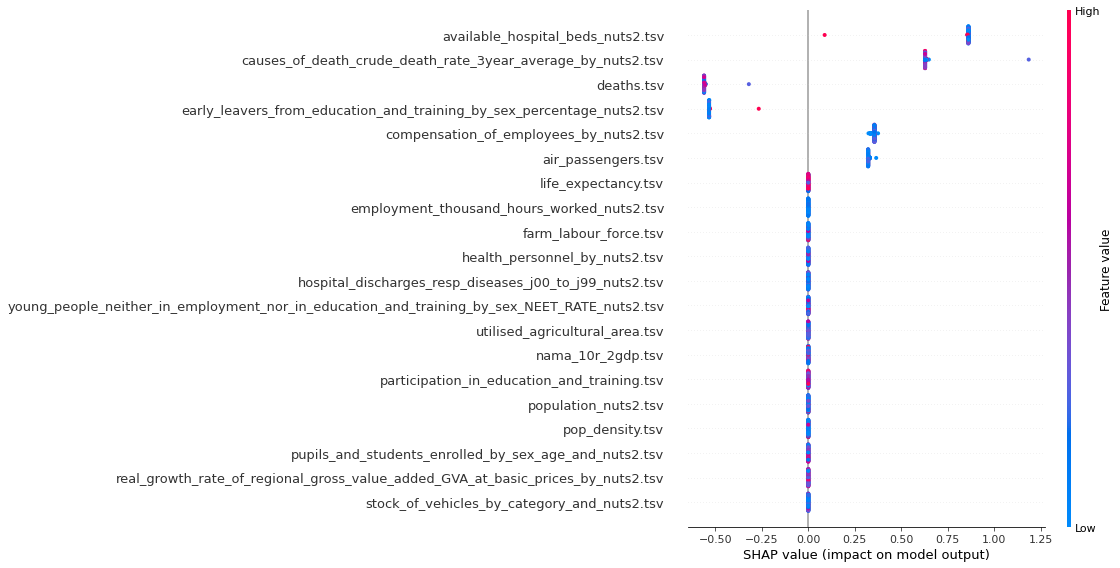

In [440]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, tm.X_train_full)
#f.savefig("shap_" + target + ".png", bbox_inches='tight', dpi=600)

In [481]:
selected_features

['employment_thousand_hours_worked_nuts2.tsv',
 'hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv',
 'life_expectancy.tsv',
 'longterm_care_beds_per_hundred_thousand_nuts2.tsv',
 'participation_in_education_and_training.tsv',
 'pop_density.tsv',
 'pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv']

['employment_thousand_hours_worked_nuts2.tsv', 'hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv', 'life_expectancy.tsv', 'longterm_care_beds_per_hundred_thousand_nuts2.tsv', 'participation_in_education_and_training.tsv', 'pop_density.tsv', 'pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv', 'real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv', 'students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv']


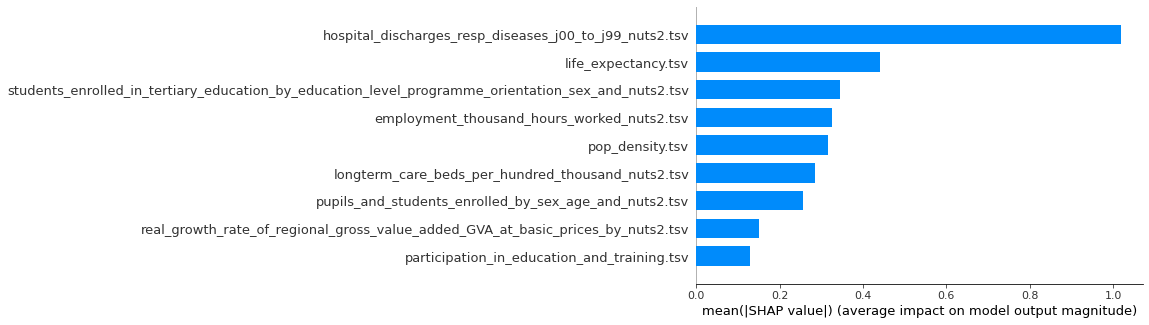

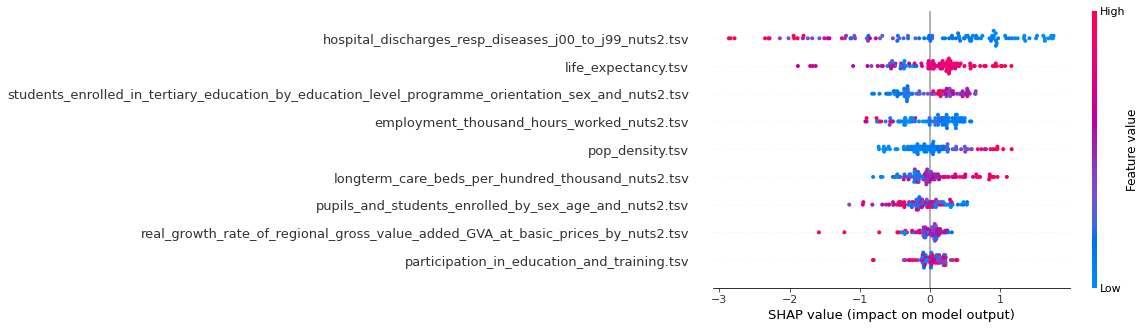

In [527]:
selected_features = tm.X_train_full.columns[tm.pipeline["feature_selection"].get_support()].tolist()
print(selected_features)
import shap
shap_values = shap.TreeExplainer(tm.trained_model).shap_values(tm.X_train_full[selected_features])
shap.summary_plot(shap_values, tm.X_train_full[selected_features], plot_type="bar")
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, tm.X_train_full[selected_features])
#plt.title(F"SHAP values summary (target: {target})")
#plt.savefig("../../9_aug_new/" +target +"_shap", bbox_inches='tight', dpi=600)

# LIME

In [508]:
import lime
import lime.lime_tabular


In [442]:
explainer = lime.lime_tabular.LimeTabularExplainer(tm.X_train_full.to_numpy(),
                        feature_names=tm.X_train_full.columns.tolist(), class_names=[target], verbose=True, mode='regression')

In [443]:
tm.df[tm.df.index == "ITC4"].iloc[:,11:-3 ]["nama_10r_2gdp.tsv"]

ITC4    398779.09
Name: nama_10r_2gdp.tsv, dtype: float64

In [448]:
tm.X_train_full.columns[tm.pipeline["feature_selection"].get_support()].tolist() 

['employment_thousand_hours_worked_nuts2.tsv',
 'hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv',
 'life_expectancy.tsv',
 'pop_density.tsv',
 'pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv',
 'real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv']

In [472]:

exp = explainer.explain_instance(val, tm.trained_model.predict)
exp.show_in_notebook(show_table=True)
#exp = explainer.explain_instance(tm.X_test[tm.X_test.index == "ITC4"].values.squeeze(), tm.trained_model.predict)
#exp.show_in_notebook(show_table=True)

IndexError: index 6 is out of bounds for axis 0 with size 6

In [528]:
explainer = lime.lime_tabular.LimeTabularExplainer(tm.X_train_full[selected_features].to_numpy(),
                        feature_names=selected_features, class_names=[target], verbose=True, mode='regression')

exp = explainer.explain_instance(tm.X_train_full[tm.X_train_full.index == "ITC4"][selected_features].values\
                                 .squeeze(), tm.trained_model.predict)
exp.show_in_notebook(show_table=True)
#exp = explainer.explain_instance(tm.X_test[tm.X_test.index == "ITC4"].values.squeeze(), tm.trained_model.predict)
#exp.show_in_notebook(show_table=True)

Intercept 5.755382816674558
Prediction_local [9.14757081]
Right: 8.524568662735778


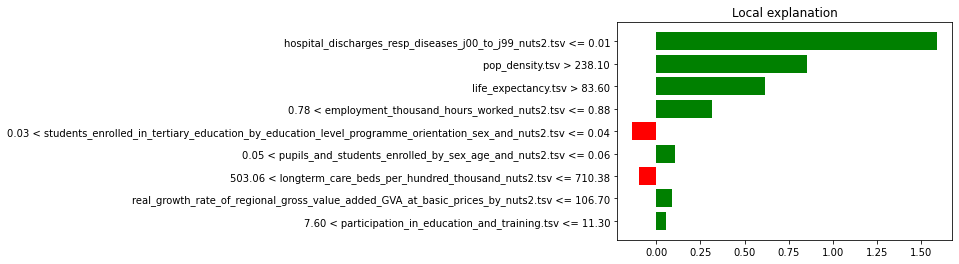

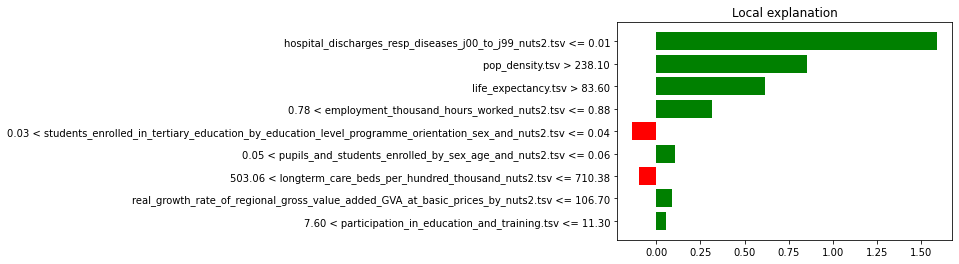

In [529]:
with open("lime_output.html", "w+", encoding="utf-8") as out:
    out.write(exp.as_html())
#exp.as_list()
exp.as_pyplot_figure()

In [475]:
tm.y_train_full[tm.y_train_full.index == "ITC4"][0]

8.543089364735449

In [90]:
tm.X_train_full[tm.X_train_full.index == "ITC4"].values.squeeze().shape

(23,)

In [392]:
df = pd.read_csv("ml_dataset.tsv", sep="\t", index_col=0)
target_origin="cum_deceased"
df = df[ (df[target_origin].isna() == False) & (df[target_origin] > 0.)  ] 

X = df.iloc[:,11:-3 ]
y = df[target_origin +"_density"] *100

df    

,cum_positive,cum_deceased,cum_recovered,curr_positive,hospitalized,intensive_care,iso3,country_name,EUCountry,EUCPMCountry,...,pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv,real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv,stock_of_vehicles_by_category_and_nuts2.tsv,students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv,unemployment_rate_nuts2.tsv,utilised_agricultural_area.tsv,young_people_neither_in_employment_nor_in_education_and_training_by_sex_NEET_RATE_nuts2.tsv,cum_positive_density,cum_deceased_density,cum_recovered_density
ITC4,856667.0,33836.0,810376.0,12455.0,283.0,35.0,ITA,Italy,True,True,...,494636.0,106.4,6967861.0,328322.0,5.0,922320.0,15.7,0.085431,0.003374,0.080815
ITH3,440420.0,11645.0,415389.0,13386.0,160.0,18.0,ITA,Italy,True,True,...,235939.0,105.3,3621253.0,120980.0,5.8,796250.0,12.6,0.090266,0.002387,0.085136
ITH5,397722.0,13287.0,374868.0,9567.0,285.0,22.0,ITA,Italy,True,True,...,212847.0,106.3,3345612.0,169485.0,5.7,1034350.0,13.2,0.089093,0.002976,0.083974
ITH1,73918.0,1184.0,72371.0,363.0,10.0,1.0,ITA,Italy,True,True,...,27774.0,107.8,570247.0,4735.0,3.8,227900.0,10.4,0.138776,0.002223,0.135871
ITG1,247040.0,6076.0,227985.0,12979.0,417.0,42.0,ITA,Italy,True,True,...,237664.0,99.8,3787735.0,119324.0,17.9,1326110.0,29.3,0.050672,0.001246,0.046763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NL12,48559.0,483.0,0.0,48076.0,572.0,NaN,NLD,Netherlands,True,True,...,45161.0,104.7,393870.0,25784.0,3.9,226440.0,4.5,0.074711,0.000743,0.000000
NL11,46456.0,257.0,0.0,46199.0,423.0,NaN,NLD,Netherlands,True,True,...,35459.0,97.4,323115.0,51402.0,5.2,162960.0,5.6,0.079295,0.000439,0.000000
AL02,64649.0,1249.0,63077.0,323.0,12.0,0.0,ALB,Albania,False,False,...,NaN,119.0,NaN,NaN,NaN,NaN,NaN,0.054962,0.001062,0.053626
PT20,6598.0,34.0,0.0,6564.0,NaN,NaN,PRT,Portugal,True,True,...,16669.0,108.5,0.0,2673.0,6.1,118590.0,17.2,0.027175,0.000140,0.000000


In [398]:
population_dependent_features = ["available_hospital_beds_nuts2.tsv",
                "deaths.tsv",
                "hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv",
                "stock_of_vehicles_by_category_and_nuts2.tsv",
                "farm_labour_force.tsv",
                "employment_thousand_hours_worked_nuts2.tsv",
                "stock_of_vehicles_by_category_and_nuts2.tsv",
                "students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv",
                "health_personnel_by_nuts2.tsv",
                "pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv",
                "early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv"]

X["available_hospital_beds_nuts2.tsv"] = X["available_hospital_beds_nuts2.tsv"] / X["population_nuts2.tsv"]


In [351]:

#df.iloc[11:-3].groupby(lambda x: x[:2]).mean()

national_means = df.iloc[:,11:-3]
national_means["iso3"] = df["iso3"]
national_means = national_means.groupby(by="iso3" ).mean()

iso3_aggregator_df = pd.DataFrame()
iso3_aggregator_df["iso3"] = df[ "iso3" ]
iso3_aggregator_df["nuts"] = iso3_aggregator_df.index
iso3_aggregator_df = iso3_aggregator_df.merge(national_means, left_on="iso3", right_on="iso3")
iso3_aggregator_df.set_index("nuts", inplace=True)

for column in X.columns:
    X[column].fillna(iso3_aggregator_df[column], inplace=True)
X

,air_passengers.tsv,available_hospital_beds_nuts2.tsv,causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv,compensation_of_employees_by_nuts2.tsv,deaths.tsv,early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv,employment_thousand_hours_worked_nuts2.tsv,farm_labour_force.tsv,health_personnel_by_nuts2.tsv,hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv,...,participation_in_education_and_training.tsv,population_nuts2.tsv,pop_density.tsv,pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv,real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv,stock_of_vehicles_by_category_and_nuts2.tsv,students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv,unemployment_rate_nuts2.tsv,utilised_agricultural_area.tsv,young_people_neither_in_employment_nor_in_education_and_training_by_sex_NEET_RATE_nuts2.tsv
ITC4,49096.0,350.53,982.92,157914.20,99983.0,11.9,8286969.60,39630.0,36969.0,102187.0,...,7.9,10027602.0,435.8,494636.0,106.4,6967861.0,328322.0,5.0,922320.0,15.7
ITH3,18404.0,328.97,995.51,65182.80,48900.0,10.5,4000567.20,84040.0,16900.0,50431.0,...,7.6,4879133.0,282.0,235939.0,105.3,3621253.0,120980.0,5.8,796250.0,12.6
ITH5,9905.0,371.56,1113.52,64216.80,50274.0,9.3,3713821.70,57200.0,19026.0,63764.0,...,9.2,4464119.0,201.9,212847.0,106.3,3345612.0,169485.0,5.7,1034350.0,13.2
ITH1,37.0,349.97,826.12,9836.20,4454.0,14.2,538871.10,14860.0,1770.0,5716.0,...,7.1,532644.0,72.2,27774.0,107.8,570247.0,4735.0,3.8,227900.0,10.4
ITG1,18182.0,281.95,1027.28,35708.90,52405.0,19.4,2618000.70,133090.0,21163.0,41725.0,...,4.7,4875290.0,192.1,237664.0,99.8,3787735.0,119324.0,17.9,1326110.0,29.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NL12,16238.8,NaN,988.31,9804.00,6256.0,6.4,438799.00,5380.0,1530.0,5173.0,...,16.4,649957.0,191.0,45161.0,104.7,393870.0,25784.0,3.9,226440.0,4.5
NL11,16238.8,NaN,962.35,10559.00,5500.0,6.1,408746.00,3110.0,3170.0,4232.0,...,19.9,585866.0,247.9,35459.0,97.4,323115.0,51402.0,5.2,162960.0,5.6
AL02,NaN,NaN,NaN,NaN,7454.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1176240.0,236.2,NaN,119.0,NaN,NaN,NaN,NaN,NaN
PT20,2836.0,611.15,943.07,1885.62,2271.0,27.0,207382.93,11640.0,861.0,NaN,...,5.8,242796.0,105.3,16669.0,108.5,0.0,2673.0,6.1,118590.0,17.2


ITC4    49096.0
ITH3    18404.0
ITH5     9905.0
ITH1       37.0
ITG1    18182.0
         ...   
NL12    16238.8
NL11    16238.8
AL02        NaN
PT20     2836.0
PT18        3.0
Name: air_passengers.tsv, Length: 92, dtype: float64

In [352]:
np.where(X.isna().values == True, 1, 0).sum()

130

In [337]:
df[df["iso3"] == "NL"].iloc[:,11:-3]

,air_passengers.tsv,available_hospital_beds_nuts2.tsv,causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv,compensation_of_employees_by_nuts2.tsv,deaths.tsv,early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv,employment_thousand_hours_worked_nuts2.tsv,farm_labour_force.tsv,health_personnel_by_nuts2.tsv,hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv,...,participation_in_education_and_training.tsv,population_nuts2.tsv,pop_density.tsv,pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv,real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv,stock_of_vehicles_by_category_and_nuts2.tsv,students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv,unemployment_rate_nuts2.tsv,utilised_agricultural_area.tsv,young_people_neither_in_employment_nor_in_education_and_training_by_sex_NEET_RATE_nuts2.tsv


In [340]:

df[df.index.isin([item for item in df.index if item.startswith("NL")] )].iloc[:,11:-3]


,air_passengers.tsv,available_hospital_beds_nuts2.tsv,causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv,compensation_of_employees_by_nuts2.tsv,deaths.tsv,early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv,employment_thousand_hours_worked_nuts2.tsv,farm_labour_force.tsv,health_personnel_by_nuts2.tsv,hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv,...,participation_in_education_and_training.tsv,population_nuts2.tsv,pop_density.tsv,pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv,real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv,stock_of_vehicles_by_category_and_nuts2.tsv,students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv,unemployment_rate_nuts2.tsv,utilised_agricultural_area.tsv,young_people_neither_in_employment_nor_in_education_and_training_by_sex_NEET_RATE_nuts2.tsv
NL13,177.0,NaN,1080.19,7537.0,5143.0,6.5,323908.0,3470.0,1446.0,3841.0,...,18.1,493682.0,184.5,32859.0,103.4,308291.0,14733.0,3.7,150220.0,5.6
NL42,440.0,NaN,1053.85,21263.0,12007.0,7.5,838211.0,4140.0,3916.0,9874.0,...,15.3,1117201.0,517.7,61681.0,107.9,661564.0,49740.0,3.5,97940.0,4.6
NL21,NaN,NaN,903.93,21914.0,10478.0,6.8,873131.0,8080.0,3066.0,8249.0,...,17.3,1162406.0,344.9,83080.0,109.8,670236.0,53974.0,3.5,198730.0,4.7
NL34,NaN,NaN,1026.48,6305.0,3934.0,7.4,267651.0,3010.0,628.0,2636.0,...,17.7,383488.0,212.6,24497.0,106.1,236250.0,10586.0,2.6,122180.0,3.5
NL41,6785.0,NaN,903.55,55531.0,22886.0,8.0,2078590.0,10780.0,6727.0,19213.0,...,17.5,2562955.0,514.8,165534.0,109.9,1609609.0,120128.0,3.5,246900.0,3.9
NL32,71690.0,NaN,811.96,77141.0,23086.0,7.4,2520883.0,4120.0,13892.0,17403.0,...,20.5,2879527.0,1041.2,186715.0,114.5,1389380.0,152371.0,3.9,128040.0,5.6
NL33,2102.0,NaN,842.33,79722.0,31224.0,7.0,2808887.0,5710.0,13658.0,26773.0,...,19.9,3744299.0,1292.2,258153.0,105.2,1802818.0,204902.0,4.4,128640.0,4.3
NL31,NaN,NaN,750.00,34954.0,9823.0,6.0,1140175.0,2620.0,7709.0,9343.0,...,22.2,1319231.0,934.6,95529.0,114.8,811443.0,79649.0,3.5,64470.0,3.7
NL22,NaN,NaN,913.87,38627.0,19079.0,6.1,1530738.0,11020.0,7666.0,16210.0,...,17.6,2085952.0,415.8,139956.0,108.2,1194949.0,101148.0,3.5,232440.0,4.3
NL23,NaN,NaN,591.63,6227.0,2469.0,9.0,262189.0,1690.0,520.0,3111.0,...,18.0,423021.0,292.5,33696.0,111.5,429317.0,16358.0,3.9,88600.0,5.5


In [240]:
X = df.iloc[:,11:-3 ]
y = df["cum_positive_density"] *100


In [364]:
def percent_avbl_nation(nation, column, dataframe):
    not_nans_for_region = dataframe[(dataframe[column].isna() == False) & 
                            dataframe["GEO (Nation Codes)"].apply(lambda x: nation == x)]
    full_for_region = dataframe[dataframe["GEO (Nation Codes)"].apply(lambda x: nation == x)]
    
    return len(not_nans_for_region) / len(full_for_region)
def percent_nans(column, dataframe):
    return len(dataframe[dataframe[column].isna()])/len(dataframe)

for column in X.columns:
    print(column, " ", percent_nans(column, X))


air_passengers.tsv   0.03260869565217391
available_hospital_beds_nuts2.tsv   0.16304347826086957
causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv   0.03260869565217391
compensation_of_employees_by_nuts2.tsv   0.10869565217391304
deaths.tsv   0.0
early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv   0.03260869565217391
employment_thousand_hours_worked_nuts2.tsv   0.10869565217391304
farm_labour_force.tsv   0.03260869565217391
health_personnel_by_nuts2.tsv   0.03260869565217391
hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv   0.11956521739130435
life_expectancy.tsv   0.0
longterm_care_beds_per_hundred_thousand_nuts2.tsv   0.29347826086956524
nama_10r_2gdp.tsv   0.07608695652173914
participation_in_education_and_training.tsv   0.03260869565217391
population_nuts2.tsv   0.0
pop_density.tsv   0.0
pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv   0.03260869565217391
real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv   0.

<BarContainer object of 23 artists>

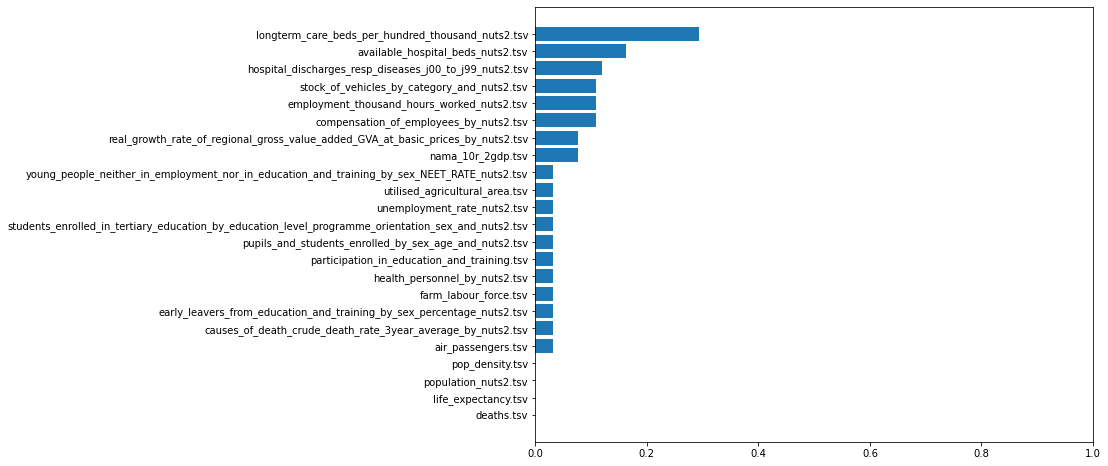

In [372]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
items = sorted([ (column, percent_nans(column, X)) for column in X.columns], key=lambda x: x[1])
plt.xlim(0,1)
plt.barh([ item[0]for item in items], [ item[1]for item in items])

In [241]:
X.fillna(X.mean(axis=0), inplace=True)
X = (X - X.mean(axis=0))/ X.std(axis=0)


In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, shuffle=True)#, stratify=mean_analysis_df["GEO (Nation Codes)"])
std = StandardScaler()
pipeline = Pipeline( steps= [#("std", StandardScaler()),
                                          ("lm", RandomForestRegressor())#RandomForestRegressor(max_depth=5, n_estimators=200))#xgb.XGBRegressor(n_estimators=500)),
                                         ])
#lm = LinearRegression()
pipeline.fit(X_train, y_train)

#cross_v
y_train_preds = pipeline.predict(X_train)
y_preds = pipeline.predict(X_test)
print(r2_score(y_train, y_train_preds))
print(r2_score(y_test, y_preds))

0.8982381176127818
0.15899223256799


In [247]:

N_SPLITS = 10

#kf = KFold(n_splits=N_SPLITS)
#kf.get_n_splits(X)


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.40, shuffle=True)#, stratify=mean_analysis_df["GEO (Nation Codes)"])

kf = KFold(n_splits=N_SPLITS)
kf.get_n_splits()

tot_train_rscore = 0
tot_valid_rscore = 0
tot_test_rscore = 0
for train_index, valid_index in kf.split(X_train_full):
    
    #print("TRAIN:", train_index, "TEST:", valid_index)
    X_train, X_valid = X_train_full.iloc[train_index], X_train_full.iloc[valid_index]
    y_train, y_valid = y_train_full.iloc[train_index], y_train_full.iloc[valid_index]
    
    
    pipeline = Pipeline( steps= [#("std", StandardScaler()),
                                          ("lm",RandomForestRegressor())#xgb.XGBRegressor(n_estimators=200, max_depth=5)),
                                             ])
    pipeline.fit(X_train, y_train)

    #cross_v
    y_train_preds = pipeline.predict(X_train)
    y_valid_preds = pipeline.predict(X_valid)
    y_test_preds = pipeline.predict(X_test)
    #print(r2_score(y_train, y_train_preds))
    #print(r2_score(y_valid, y_preds))
    tot_train_rscore += r2_score(y_train, y_train_preds)
    tot_valid_rscore += r2_score(y_valid, y_valid_preds)
    tot_test_rscore += r2_score(y_test, y_test_preds)
print("Train: ", tot_train_rscore/N_SPLITS) 
print("Valid: ", tot_valid_rscore/N_SPLITS)
print("Test: ", tot_test_rscore/N_SPLITS)

trained_model = pipeline["lm"]

for feature, importance in sorted(zip(X.columns, trained_model.feature_importances_), key=lambda x: x[1], reverse=True ):
    print(feature, " ", importance)
    

Train:  0.8947165871902885
Valid:  0.24258966857612269
Test:  0.3233929055460991
life_expectancy.tsv   0.17854658805639723
pop_density.tsv   0.17042050199854963
participation_in_education_and_training.tsv   0.07866177969142228
available_hospital_beds_nuts2.tsv   0.07681405641493505
hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv   0.04741389709149474
early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv   0.0391801411733084
stock_of_vehicles_by_category_and_nuts2.tsv   0.03501687193253164
pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv   0.03327020540480311
real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv   0.03312314600364029
causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv   0.032453933971880115
farm_labour_force.tsv   0.028982859826991732
unemployment_rate_nuts2.tsv   0.02843601355380364
young_people_neither_in_employment_nor_in_education_and_training_by_sex_NEET_RATE_nuts2.tsv   0.0283990316317364
nama_10r_2gdp.

In [203]:
trained_model = pipeline["lm"]

for feature, importance in sorted(zip(X.columns, trained_model.feature_importances_), key=lambda x: x[1], reverse=True ):
    print(feature, " ", importance)
    

life_expectancy.tsv   0.24388879311513573
longterm_care_beds_per_hundred_thousand_nuts2.tsv   0.07107519458457147
real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv   0.06377398589743476
pop_density.tsv   0.05502894073240974
participation_in_education_and_training.tsv   0.05367582987509163
pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv   0.04938311254391074
causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv   0.048964871828883025
unemployment_rate_nuts2.tsv   0.04578722914921249
early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv   0.042861015083985765
young_people_neither_in_employment_nor_in_education_and_training_by_sex_NEET_RATE_nuts2.tsv   0.04240026476385794
employment_thousand_hours_worked_nuts2.tsv   0.035909886459240196
hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv   0.031865365926066314
students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv   0.03018224986398452

In [222]:
out_df = pd.DataFrame()

#if includes also categorical
#out_df[df.columns[:11]]= df.iloc[:,:11 ]
out_df[df.columns[-3:]]= df.iloc[:,-3: ]
#out_df[df.columns[:6]]= df.iloc[:,:6 ]

out_df[X.columns] = X


In [223]:
out_df

,cum_positive_density,cum_deceased_density,cum_recovered_density,air_passengers.tsv,available_hospital_beds_nuts2.tsv,causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv,compensation_of_employees_by_nuts2.tsv,deaths.tsv,early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv,employment_thousand_hours_worked_nuts2.tsv,...,participation_in_education_and_training.tsv,population_nuts2.tsv,pop_density.tsv,pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv,real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv,stock_of_vehicles_by_category_and_nuts2.tsv,students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv,unemployment_rate_nuts2.tsv,utilised_agricultural_area.tsv,young_people_neither_in_employment_nor_in_education_and_training_by_sex_NEET_RATE_nuts2.tsv
ITC4,0.084985,0.003373,0.080592,3.117492,-0.411887,-0.161293,5.526463e+00,5.101050,0.168025,5.544048e+00,...,-0.612886,5.013451,0.150741,4.068790,-4.821979e-01,5.327166,3.542032,-5.342815e-01,0.352790,0.805419
ITH3,0.089351,0.002386,0.084520,0.723851,-0.537448,-0.106162,1.700606e+00,1.945886,-0.101699,2.082955e+00,...,-0.650280,1.905360,-0.046225,1.394922,-6.780014e-01,2.290470,0.711346,-3.672777e-01,0.200243,0.257628
ITH5,0.088177,0.002975,0.083748,0.061022,-0.289413,0.410591,1.660751e+00,2.030752,-0.332892,1.851420e+00,...,-0.450848,1.654819,-0.148806,1.156245,-4.999982e-01,2.040354,1.373549,-3.881532e-01,0.488348,0.363652
ITH1,0.138507,0.002221,0.135648,-0.708574,-0.415148,-0.847903,-5.828515e-01,-0.799340,0.611144,-7.122219e-01,...,-0.712602,-0.718582,-0.314908,-0.756653,-2.329935e-01,-0.477999,-0.875661,-7.847871e-01,-0.487469,-0.131128
ITG1,0.049650,0.001240,0.046361,0.706537,-0.811282,0.032955,4.845890e-01,2.162374,1.612977,9.665894e-01,...,-1.011750,1.903040,-0.161357,1.412751,-1.657019e+00,2.441535,0.688738,2.158654e+00,0.841382,3.208635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE11,0.108517,0.000000,0.000000,1.471688,-1.264663,-1.473778,1.778623e+00,-0.125232,-0.698946,5.339605e-01,...,2.154233,0.394890,0.055972,1.160265,4.612190e-01,-0.007805,0.297737,8.480658e-03,-0.651910,-0.784944
UKD4,0.035446,0.000000,0.000000,-0.710290,0.000000,0.230662,1.500936e-16,-0.079464,0.148759,-3.760023e-16,...,0.097590,-0.137423,0.214390,0.000000,-2.529577e-15,-0.270809,0.000000,-8.056625e-01,-0.498577,0.452005
AL02,0.054793,0.001062,0.053568,0.000000,0.000000,0.000000,1.500936e-16,-0.614044,0.000000,-3.760023e-16,...,0.000000,-0.330048,-0.104880,0.000000,1.760642e+00,0.000000,0.000000,1.854114e-16,0.000000,0.000000
PT20,0.027348,0.000140,0.000000,-0.490283,1.105906,-0.335791,-9.108718e-01,-0.934174,3.077196,-9.798849e-01,...,-0.874641,-0.893561,-0.272518,-0.871433,-1.083912e-01,-0.995438,-0.903812,-3.046513e-01,-0.619736,1.070480


In [225]:
out_df.to_csv("eurostat_db.csv")